<a href="https://colab.research.google.com/github/Nandu2717/EfficientNetb7-Tensorflow/blob/main/custom_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/rice/Rice_Image_Dataset.zip" -d "/content/drive/MyDrive/rice/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: /content/drive/MyDrive/rice/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: /content/

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install split-folders

In [ ]:
base_ds = '/content/drive/MyDrive/rice/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [ ]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)


Copying files: 75000 files [04:45, 262.36 files/s]


In [ ]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


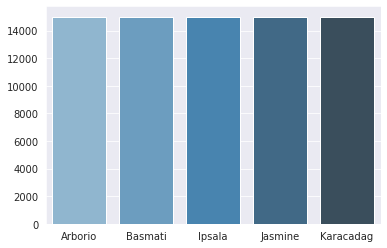

In [ ]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

In [ ]:
batch_size = 128
img_height, img_width = 224,224
input_shape = (img_height, img_width, 3)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history1 = model_vanilla.fit(train_ds, epochs = 5, validation_data = val_ds, callbacks=callbacks)

Epoch 1/5
411/411 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9871
Epoch 1: val_accuracy improved from 0.51724 to 0.55173, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 696s 2s/step - loss: 0.0399 - accuracy: 0.9871 - val_loss: 20.5312 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 2/5
411/411 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9919
Epoch 2: val_accuracy improved from 0.55173 to 0.97600, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 696s 2s/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.0827 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 3/5
411/411 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9914
Epoch 3: val_accuracy did not improve from 0.97600
411/411 [==============================] - 693s 2s/step - loss: 0.0274 - accuracy: 0.9914 - val_loss: 36.5270 - val_accuracy: 0.3882 - lr: 0.0010
Epoch 4/5
411/411 [

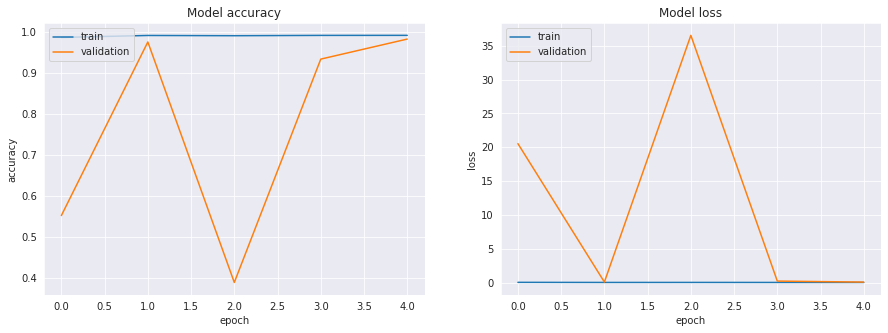

In [ ]:
model_vanilla.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(history1)

In [ ]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

88/88 [==============================] - 38s 428ms/step - loss: 0.0738 - accuracy: 0.9802


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)

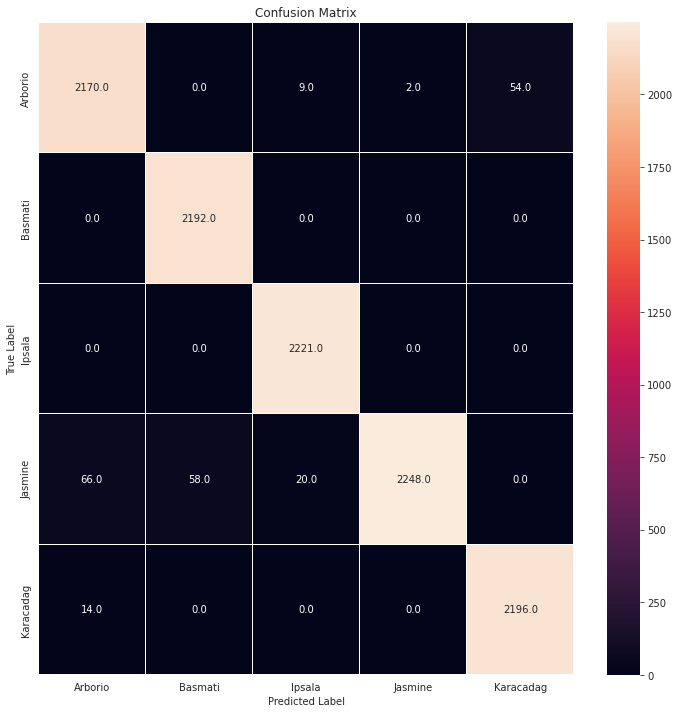

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.970917,0.964444,0.967670,2250.000000
Basmati,1.000000,0.974222,0.986943,2250.000000
Ipsala,1.000000,0.987111,0.993514,2250.000000
Jasmine,0.939799,0.999111,0.968548,2250.000000
Karacadag,0.993665,0.976000,0.984753,2250.000000
accuracy,0.980178,0.980178,0.980178,0.980178
macro avg,0.980876,0.980178,0.980286,11250.000000
weighted avg,0.980876,0.980178,0.980286,11250.000000
